In [1]:
import gym
import numpy as np
import tensorflow as tf
import keras
import keras.layers as L
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Using TensorFlow backend.


In [2]:
def make_env():
    
    env = gym.make('CartPole-v0').env
    return env

class Reinforce(object):
    
    def __init__(self, state_shape, actions_n, lr = 0.0005, gamma = 0.99):
        
        self.lr = lr
        self.gamma = gamma
        self.actions_n = actions_n
               
        # define placeholders
        self.states = tf.placeholder('float32', (None,) + state_shape)
        self.actions = tf.placeholder('int32')
        self.cumulative_rewards = tf.placeholder('float32')
        
        # define model
        network = keras.models.Sequential()
        network.add(L.InputLayer(input_shape = (None,) + state_shape))
        network.add(L.Dense(100, activation='relu'))
        network.add(L.Dense(100, activation='relu'))
        network.add(L.Dense(2, activation='linear'))
        sess.run(tf.global_variables_initializer())

        logits = network(self.states)
        self.policy = tf.nn.softmax(logits)
        log_policy = tf.nn.log_softmax(logits)
        
        # define loss
        log_policy_actions = tf.reduce_sum(tf.one_hot(self.actions, self.actions_n) * log_policy, axis = 1)
        J = tf.reduce_mean(log_policy_actions * self.cumulative_rewards)
        
        # entropy
        entropy = tf.reduce_mean(tf.multiply(self.policy, log_policy))
        
        self.loss = - J - (0.1 * entropy)
        self.update = tf.train.AdamOptimizer(self.lr).minimize(self.loss, var_list = network.weights)        
        
    def get_action_proba(self, s):
        return self.policy.eval({self.states:[s]})[0] 
        
    def _cumulative_rewards(self, rewards, cum_rewards = []):
               
        if len(rewards) == len(cum_rewards):
            return cum_rewards
        
        times = len(rewards) - len(cum_rewards)
        cum_r = sum([(self.gamma ** t) * rewards[t + len(cum_rewards)] for t in range(times)])
        cum_rewards.append(cum_r)
        
        return self._cumulative_rewards(rewards, cum_rewards)
        
    def train_agent(self, _s, _a, _r):
        
        cum_rewards = self._cumulative_rewards(_r, cum_rewards = [])
        _, loss = sess.run([self.update, self.loss], {self.states: _s, self.actions: _a, self.cumulative_rewards: cum_rewards})
        return loss
               
    def generate_session(self, t_max=1000, train = False):
        
        loss = None
        _s, _a, _r = [],[],[]   
        s = env.reset()
    
        for t in range(t_max):
        
            action_probas = self.get_action_proba(s)
            a = np.random.choice(range(self.actions_n), p = action_probas)
        
            new_s, r, done, info = env.step(a)
        
            _s.append(s)
            _a.append(a)
            _r.append(r)
        
            s = new_s
        
            if done: 
                break
                
        if train:
            loss = self.train_agent(_s, _a, _r)
            
        return sum(_r), loss

In [3]:
env = make_env()
Reinf = Reinforce(env.observation_space.shape, env.action_space.n, lr=0.0005)

/home/mkj/.conda/envs/RLsolutions/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


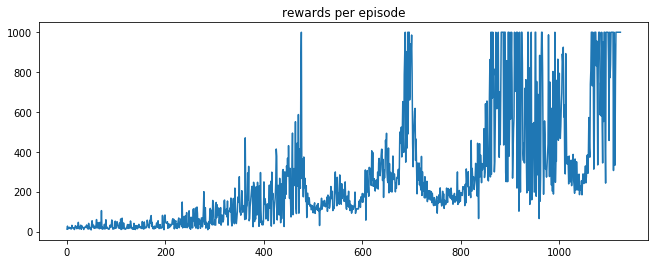

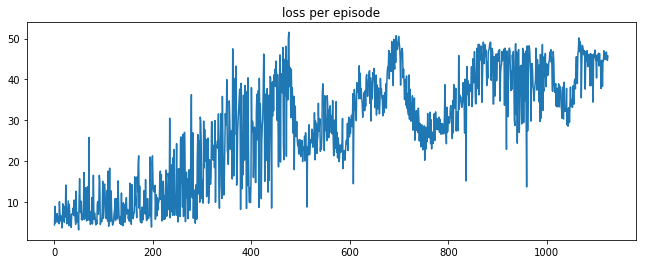

rewards: 1000 points!


In [18]:
sess.run(tf.global_variables_initializer())
mean_r = []
mean_loss = []
times = 0

for i in range(25):
        
    for _ in range(125):
        
        rewards, loss = Reinf.generate_session(train = True)
        mean_r.append(rewards)
        mean_loss.append(loss)
        
    clear_output(True)
    
    plt.figure(figsize=[24, 4])
    plt.subplot(1, 2, 1)
    plt.plot(mean_r)
    plt.title('rewards per episode')
    
    plt.figure(figsize=[24, 4])
    plt.subplot(1, 2, 2)
    plt.plot(mean_loss)
    plt.title('loss per episode')
    
    plt.show()
    
    if np.mean(rewards) >= 1000:
        print ("rewards: 1000 points!")
        break
        

In [19]:
# lets test it...
np.mean([Reinf.generate_session()[0] for _ in range(20)])

886.15